# Graph Exploratory Data Analysis

This notebook performs graph exploratory data analysis and generate some graph statistics

## Import Libraries

In [328]:
#import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(11,6)})

import os 
import configparser
import csv
import hashlib

In [329]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip3 install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Successfully imported GraphDataScience


# Custom Functions

In [330]:
# function adapted from Neo4j GDS Fraud Demo Notebook (h/t Zach B.)
def read_neo4j_properties(NEO4J_PROPERTIES_FILE: str=None) -> str:
  '''Parses Neo4j database or Aura connection details from provided .ini filepath.
  Requirements:
    configparser

  Args:
    NEO4J_PROPERTIES_FILE: path to a .ini file
  
  Returns:
    HOST: link to Neo4j or Aura host 
    USERNAME: login username
    PASSWORD: login password 

  Note: The .ini file should use the following syntax
    [NEO4J]
    PASSWORD=<password>
    USERNAME=<database name>
    HOST=<host uri>

  If no path is passed, the function will return the defaults:
    HOST = 'neo4j://localhost'
    USERNAME = 'neo4j'
    PASSWORD = 'password'
  '''

  if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
      config = configparser.RawConfigParser()
      config.read(NEO4J_PROPERTIES_FILE)
      HOST = config['NEO4J']['HOST']
      USERNAME = config['NEO4J']['USERNAME']
      PASSWORD = config['NEO4J']['PASSWORD']
      print('Using HOST, USERNAME, PASSWORD from .ini file')
      return HOST, USERNAME, PASSWORD
  else:
      print('Could not find database properties file, using defaults:')
      HOST = 'neo4j://localhost'
      USERNAME = 'neo4j'
      PASSWORD = 'password'
      print(f'HOST: {HOST} \nUSERHAME: {USERNAME} \nPASSWORD: {PASSWORD}')
      return HOST, USERNAME, PASSWORD 
    

In [331]:
# function to generate graph statistics in terms of nodeCount, labelCount, propertyKeyCount, relationshipCount and relationshipType count
def gen_graph_counts(df: pd.DataFrame) -> None:
  '''return count columns from output of apoc.meta.stats()

  Args:
    df: dataframe containing output of apoc.meta.stats()

  Returns:
    print count columns to notebook 
  '''

  print(summary_df[['nodeCount', 'labelCount', 'propertyKeyCount', 'relCount', 'relTypeCount']].transpose())

In [332]:
# function to generate node label count
def gen_nodeLabel_count(summary_df: pd.DataFrame) -> None:
  '''import summary_df and return dataframe with node label count
  args:
    summary_df: dataframe returned from apoc.meta.stats()
  
  returns:
    Nothing; will print the dataframe to the notebook
  '''
  # generate a new dataframe from the nested dictionary in the 'labels' column
  labels_df = pd.DataFrame(summary_df['labels']['values'].items()).set_index(0)

  # rename the index and column
  labels_df.columns = ['nodeCount']
  labels_df.index.rename('nodeLabel', inplace=True)

  # sort by descending count 
  labels_df.sort_values(by='nodeCount', ascending=False, inplace=True)
  print(labels_df)

In [333]:
# function to generate node property statistics
def gen_nodeLabel_properties() -> None:
  '''cypher call for properties; return node properties table
  args:
    None

  returns:
    Nothing; prints dataframe to notebook
  '''
  # query for nodeProperty schema dataframe 
  node_properties_df = gds.run_cypher('''CALL db.schema.nodeTypeProperties()''')

  # remove extra text from nodeType column and sort
  node_properties_df['nodeType'] = node_properties_df['nodeType'].str.replace('`', '')
  node_properties_df['nodeType'] = node_properties_df['nodeType'].str.replace(':', '', 1)
  node_properties_df['nodeType'] = node_properties_df['nodeType'].str.replace(':', '|')
  node_properties_df.sort_values(by=['nodeType', 'propertyName'], inplace=True)

  # view dimensions 
  print(node_properties_df)

In [334]:
# function to generate graph relationship patterns.
def gen_graph_rel_patterns(summary_df: pd.DataFrame) -> None:
  '''generate list of graph relationship patterns from apoc.meta.stats()
  '''
  # extract nested dictionary into a dataframe 
  graphPatterns_df = pd.DataFrame(summary_df['relTypes']['values'].items())

  # # rename columns and set an index 
  graphPatterns_df.rename(columns = {0: 'relPattern', 1:'relCount'}, inplace=True)
  graphPatterns_df.set_index('relPattern', inplace=True)

  # sort descending
  graphPatterns_df.sort_values(by=['relCount', 'relPattern'], ascending=False, inplace=True)

  print(graphPatterns_df)

In [335]:
# function to genereate relationship type count
def gen_relType_count(summary_df: pd.DataFrame) -> None:
  '''generate relationship type count from apoc.meta.stats()
  inputs:
    summary_df: output from apoc.meta.stats()
  '''
  # generate a new dataframe from the nested dictionary in the 'labels' column
  relTypes_df = pd.DataFrame(summary_df['relTypesCount']['values'].items()).set_index(0)

  # rename the index and column
  relTypes_df.columns = ['relCount']
  relTypes_df.index.rename('relType', inplace=True)

  # sort by descending count 
  relTypes_df.sort_values(by='relCount', ascending=False, inplace=True)
  print(relTypes_df)

In [336]:
# function to generate relationship properties
def gen_relType_properties() -> None:
  '''generate and print table of relationship properties
  inputs:
    None

  outputs:
    None; prints table to notebook
  '''
  # query for schema dataframe 
  rel_properties_df = gds.run_cypher('''CALL db.schema.relTypeProperties()''')

  # remove extra text from nodeType column
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace('`', '')
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace(':', '')

  # view dimensions 
  print(rel_properties_df.sort_values(by='relType', ascending=True))

In [337]:
# function to generate statistics from an array of node degree values
def gen_apoc_stats(df: pd.DataFrame, col: str) -> None:
  '''generate statistics from an array of node degree values
  inputs:
    df: dataframe containing the degree values
    col: df column to perform the calculation on
  '''
  return round(df[col].describe(percentiles=[.25, .5, .75, .9, .95, .99]), 2)

# Connect to Neo4j DB
It is recommended to store authentication credentials in a separate file and read them in to the notebook as variables. This code assumes the files are stored in a local auth directory.

In [338]:
# get authentication credentials from local auth file
NEO4J_PROPERTIES_FILE = 'auth/immerse_kg_auth.ini'
HOST, USERNAME, PASSWORD = read_neo4j_properties(NEO4J_PROPERTIES_FILE=NEO4J_PROPERTIES_FILE)

Using HOST, USERNAME, PASSWORD from .ini file


In [339]:
# connect to neo4j instance 
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=False)

In [340]:
# confirm connection with GDS version 
gds.version()

'2.5.2'

# High-Level Graph Database overview

## View Graph Database Schema in Browser
* There is no one 'right way' to perform Exploratory Data Analysis (EDA) on a data set and Graph EDA is an emerging area of Graph Data Science (GDS) with few established best practices. 
* Neo4j has multiple tools available and we want to use any and all of them that can be most beneficial.
* It is always recommended to call `CALL db.schema.visualization()` on the data from the Neo4j Browser to view the data model. It will not render if called from the Python GDS client.
  * At a minimum, review the schema and confirm it passes the *common sense test* especially if you loaded the data manually. 
  * If possible, compare it to an expected model as well to identify any potential errors or other data schema issues. 

## Data Summary
Calling `apoc.meta.stats()` will yield an output (or in this case, a DataFrame) containing several high level statistics about the contents of our graph database.  

There are multiple ways we can work with this data, either in Python itself or through multiple Cypher calls to the database. However it may be preferrable for some to make one Cypher call to the database and then work with the returned DataFrame.

In [341]:
# return full dataframe of summary data 
summary_df = gds.run_cypher('''
                            CALL apoc.meta.stats()
                            YIELD *
                            ''')

# set a named index, rather than the default 0
summary_df.index = ['values']

# view dimensions of dataframe
summary_df.shape

(1, 9)

## Summary Statistics

In [342]:
summary_df

,labelCount,relTypeCount,propertyKeyCount,nodeCount,relCount,labels,relTypes,relTypesCount,stats
values,7,12,40,3507,8016,"{'OntologicalConcept': 66, 'Effector': 1292, 'TextMining': 2713, 'DictionaryConcept': 638, 'BookChapter': 1, 'Affected': 1420, 'Article': 89}","{'(:TextMining)-[:NEGATIVELY_CORRELATED]->()': 194, '()-[:POSITIVELY_CORRELATED]->(:Affected)': 420, '()-[:CORRELATED_NOT_SPECIFIED]->(:TextMining)': 1241, '(:Affected)-[:HAS_CANONICAL_NAME]->()': 1419, '(:OntologicalConcept)-[:IS_OBJECT_OF_CATALYST]->()': 1, '(:OntologicalConcept)-[:SUB_CLASS_OF]->()': 47, '()-[:CORRELATED_NOT_SPECIFIED]->(:Affected)': 1240, '()-[:IS_MENTIONED_IN]->(:Article)': 2106, '(:Effector)-[:POSITIVELY_CORRELATED]->()': 420, '()-[:HAS_CANONICAL_NAME]->()': 2710, '()-[:IS_OBJECT_OF_CATALYST]->(:OntologicalConcept)': 1, '(:Effector)-[:NOT_CORRELATED]->()': 55, '()-[:IS_CATALYST_OF]->(:OntologicalConcept)': 1, '(:OntologicalConcept)-[:IS_CATALYST_OF]->()': 1, '()-[:IS_RESULT_OF]->()': 1, '()-[:NOT_CORRELATED]->(:Affected)': 55, '()-[:NEGATIVELY_CORRELATED]->(:TextMining)': 194, '()-[:IS_OBJECT_OF_CATALYST]->()': 1, '()-[:POSITIVELY_CORRELATED]->(:TextMining)': 420, '(:DictionaryConcept)-[:IS_INSTANCE_OF]->()': 632, '(:OntologicalConcept)-[:PLAY_ROLE_OF]->()': 1, '(:Effector)-[:CORRELATED_NOT_SPECIFIED]->()': 1241, '()-[:NOT_CORRELATED]->(:TextMining)': 55, '()-[:IS_MENTIONED_IN]->()': 2713, '(:Affected)-[:IS_MENTIONED_IN]->()': 1420, '()-[:SUB_CLASS_OF]->(:OntologicalConcept)': 47, '()-[:PLAY_ROLE_OF]->(:OntologicalConcept)': 1, '()-[:IS_CATALYST_OF]->()': 1, '()-[:POSITIVELY_CORRELATED]->()': 420, '(:Effector)-[:NEGATIVELY_CORRELATED]->()': 194, '()-[:NEGATIVELY_CORRELATED]->(:Affected)': 194, '()-[:CORRELATED_NOT_SPECIFIED]->()': 1241, '(:TextMining)-[:NOT_CORRELATED]->()': 55, '()-[:IS_MENTIONED_IN]->(:BookChapter)': 607, '(:Effector)-[:HAS_CANONICAL_NAME]->()': 1291, '(:TextMining)-[:CORRELATED_NOT_SPECIFIED]->()': 1241, '()-[:IS_INSTANCE_OF]->(:OntologicalConcept)': 632, '(:Effector)-[:IS_MENTIONED_IN]->()': 1292, '()-[:IS_INSTANCE_OF]->()': 632, '(:TextMining)-[:IS_MENTIONED_IN]->()': 2713, '()-[:NOT_CORRELATED]->()': 55, '(:OntologicalConcept)-[:IS_RESULT_OF]->()': 1, '(:TextMining)-[:HAS_CANONICAL_NAME]->()': 2710, '()-[:SUB_CLASS_OF]->()': 47, '()-[:NEGATIVELY_CORRELATED]->()': 194, '()-[:PLAY_ROLE_OF]->()': 1, '()-[:IS_RESULT_OF]->(:OntologicalConcept)': 1, '(:TextMining)-[:POSITIVELY_CORRELATED]->()': 420, '()-[:HAS_CANONICAL_NAME]->(:DictionaryConcept)': 2710}","{'NOT_CORRELATED': 55, 'IS_OBJECT_OF_CATALYST': 1, 'HAS_CANONICAL_NAME': 2710, 'NEGATIVELY_CORRELATED': 194, 'IS_MENTIONED_IN': 2713, 'IS_INSTANCE_OF': 632, 'PLAY_ROLE_OF': 1, 'IS_RESULT_OF': 1, 'CORRELATED_NOT_SPECIFIED': 1241, 'IS_CATALYST_OF': 1, 'POSITIVELY_CORRELATED': 420, 'SUB_CLASS_OF': 47}","{'relTypeCount': 12, 'labelCount': 7, 'relTypes': {'(:TextMining)-[:NEGATIVELY_CORRELATED]->()': 194, '()-[:POSITIVELY_CORRELATED]->(:Affected)': 420, '()-[:CORRELATED_NOT_SPECIFIED]->(:TextMining)': 1241, '(:Affected)-[:HAS_CANONICAL_NAME]->()': 1419, '(:OntologicalConcept)-[:IS_OBJECT_OF_CATALYST]->()': 1, '(:OntologicalConcept)-[:SUB_CLASS_OF]->()': 47, '()-[:CORRELATED_NOT_SPECIFIED]->(:Affected)': 1240, '()-[:IS_MENTIONED_IN]->(:Article)': 2106, '(:Effector)-[:POSITIVELY_CORRELATED]->()': 420, '()-[:HAS_CANONICAL_NAME]->()': 2710, '()-[:IS_OBJECT_OF_CATALYST]->(:OntologicalConcept)': 1, '(:Effector)-[:NOT_CORRELATED]->()': 55, '()-[:IS_CATALYST_OF]->(:OntologicalConcept)': 1, '(:OntologicalConcept)-[:IS_CATALYST_OF]->()': 1, '()-[:IS_RESULT_OF]->()': 1, '()-[:NOT_CORRELATED]->(:Affected)': 55, '()-[:NEGATIVELY_CORRELATED]->(:TextMining)': 194, '()-[:IS_OBJECT_OF_CATALYST]->()': 1, '()-[:POSITIVELY_CORRELATED]->(:TextMining)': 420, '(:DictionaryConcept)-[:IS_INSTANCE_OF]->()': 632, '(:OntologicalConcept)-[:PLAY_ROLE_OF]->()': 1, '(:Effector)-[:CORRELATED_NOT_SPECIFIED]->()': 1241, '()-[:NOT_CORRELATED]->(:TextMining)': 55, '()-[:IS_MENTIONED_IN]->()': 2713, '(:Affected)-[:I

## Graph Value Counts

In [343]:
# use function defined above
gen_graph_counts(df=summary_df)

                  values
nodeCount           3507
labelCount             7
propertyKeyCount      40
relCount            8016
relTypeCount          12


# Nodes

## Node Label Count

In [344]:
# use function defined above
gen_nodeLabel_count(summary_df=summary_df)

                    nodeCount
nodeLabel                    
TextMining               2713
Affected                 1420
Effector                 1292
DictionaryConcept         638
Article                    89
OntologicalConcept         66
BookChapter                 1


## Node Label Properties

In [345]:
# use function defined above
gen_nodeLabel_properties()

               nodeType              nodeLabels    propertyName propertyTypes  \
38  Affected|TextMining  [Affected, TextMining]        arg_type      [String]   
39  Affected|TextMining  [Affected, TextMining]            base      [String]   
44  Affected|TextMining  [Affected, TextMining]            coid      [String]   
47  Affected|TextMining  [Affected, TextMining]          doc_id      [String]   
48  Affected|TextMining  [Affected, TextMining]     doc_id_type      [String]   
33  Affected|TextMining  [Affected, TextMining]            head      [String]   
32  Affected|TextMining  [Affected, TextMining]              id      [String]   
46  Affected|TextMining  [Affected, TextMining]            isbn      [String]   
40  Affected|TextMining  [Affected, TextMining]            kgDC      [Double]   
43  Affected|TextMining  [Affected, TextMining]      kgPageRank      [Double]   
42  Affected|TextMining  [Affected, TextMining]           kgScc        [Long]   
41  Affected|TextMining  [Af

# Relationships

## Relationship Type Count

In [346]:
# using the summary_df 
gen_relType_count(summary_df)
#gen_relType_count(summary_df[summary_df['relType']!='NA'])

                          relCount
relType                           
IS_MENTIONED_IN               2713
HAS_CANONICAL_NAME            2710
CORRELATED_NOT_SPECIFIED      1241
IS_INSTANCE_OF                 632
POSITIVELY_CORRELATED          420
NEGATIVELY_CORRELATED          194
NOT_CORRELATED                  55
SUB_CLASS_OF                    47
IS_OBJECT_OF_CATALYST            1
PLAY_ROLE_OF                     1
IS_RESULT_OF                     1
IS_CATALYST_OF                   1


## Relationship Type Properties

In [347]:
gen_relType_properties()

                     relType propertyName propertyTypes  mandatory
4   CORRELATED_NOT_SPECIFIED    sent_text      [String]       True
5   CORRELATED_NOT_SPECIFIED      trigger      [String]       True
6   CORRELATED_NOT_SPECIFIED      section      [String]       True
7   CORRELATED_NOT_SPECIFIED  doc_id_type      [String]       True
8   CORRELATED_NOT_SPECIFIED       doc_id      [String]       True
20        HAS_CANONICAL_NAME         None          None      False
2             IS_CATALYST_OF         None          None      False
27            IS_INSTANCE_OF         None          None      False
19           IS_MENTIONED_IN         None          None      False
21     IS_OBJECT_OF_CATALYST         None          None      False
1               IS_RESULT_OF         None          None      False
18     NEGATIVELY_CORRELATED       doc_id      [String]       True
17     NEGATIVELY_CORRELATED  doc_id_type      [String]       True
16     NEGATIVELY_CORRELATED      section      [String]       

## Relationship Patterns

In [348]:
gen_graph_rel_patterns(summary_df)

                                                    relCount
relPattern                                                  
(:TextMining)-[:IS_MENTIONED_IN]->()                    2713
()-[:IS_MENTIONED_IN]->()                               2713
(:TextMining)-[:HAS_CANONICAL_NAME]->()                 2710
()-[:HAS_CANONICAL_NAME]->(:DictionaryConcept)          2710
()-[:HAS_CANONICAL_NAME]->()                            2710
()-[:IS_MENTIONED_IN]->(:Article)                       2106
(:Affected)-[:IS_MENTIONED_IN]->()                      1420
(:Affected)-[:HAS_CANONICAL_NAME]->()                   1419
(:Effector)-[:IS_MENTIONED_IN]->()                      1292
(:Effector)-[:HAS_CANONICAL_NAME]->()                   1291
(:TextMining)-[:CORRELATED_NOT_SPECIFIED]->()           1241
(:Effector)-[:CORRELATED_NOT_SPECIFIED]->()             1241
()-[:CORRELATED_NOT_SPECIFIED]->(:TextMining)           1241
()-[:CORRELATED_NOT_SPECIFIED]->()                      1241
()-[:CORRELATED_NOT_SPEC

# Node Degree Statistics
The objective is to calculate the in-degree or out-degree of specific node and relationship combinations. 

Can generate aggregate node statistics using multiple approaches:
* Cypher query passing the results to `apoc.agg.statistics()`
* Return array to a pandas DataFrame and pass to `.describe()`.

## All Nodes

In [349]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of all nodes
inDegree_stats = gds.run_cypher('''
    MATCH (n)
    WITH n, 
      COUNT { (n)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

inDegree_stats['stats'][0]

{'total': 3507,
 'min': 0,
 '0.5': 1,
 'stdev': 12.869303250344752,
 '0.99': 41,
 'minNonZero': 1.0,
 'max': 607,
 '0.95': 8,
 'mean': 2.2857142857142856,
 '0.9': 3,
 '0.75': 1}

In [350]:
# Generate a pandas DataFrame for the inDegree of all nodes
inDegree_data = gds.run_cypher('''
  MATCH (n)
  WITH n 
  RETURN COUNT { (n)<-[]-() } AS inDegree
''')

inDegree_data.shape

(794, 1)

In [351]:
# Generate statistics from an array of all nodes inDegree values using .describe() 
gen_apoc_stats(df=inDegree_data, col='inDegree')

count    794.00
mean       7.69
std       26.30
min        0.00
25%        0.00
50%        1.00
75%        6.00
90%       17.70
95%       37.05
99%       75.19
max      607.00
Name: inDegree, dtype: float64

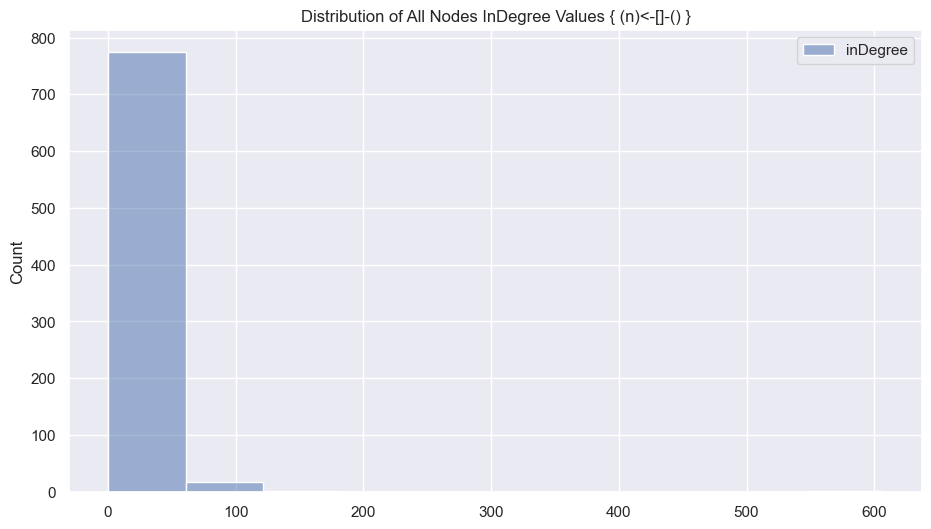

In [352]:
# Plot the distribution of all nodes inDegree values
sns.histplot(inDegree_data, bins=10).set(title='Distribution of All Nodes InDegree Values { (n)<-[]-() }')
plt.show()

In [353]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of all nodes
outDegree_stats = gds.run_cypher('''
    MATCH (n)
    WITH n, 
      COUNT { (n)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

outDegree_stats['stats'][0]

{'total': 3507,
 'min': 0,
 '0.5': 2,
 'stdev': 1.1899342935465662,
 '0.99': 6,
 'minNonZero': 1.0,
 'max': 13,
 '0.95': 4,
 'mean': 2.2857142857142856,
 '0.9': 4,
 '0.75': 3}

In [354]:
# Generate a pandas DataFrame for the outDegree of all nodes
outDegree_data = gds.run_cypher('''
  MATCH (n)
  WITH n 
  RETURN COUNT { (n)-[]->() } AS outDegree
''')

outDegree_data.shape

(3507, 1)

In [355]:
# Generate statistics from an array of all nodes outDegree values using .describe() 
gen_apoc_stats(df=outDegree_data, col='outDegree')

count    3507.00
mean        2.29
std         1.19
min         0.00
25%         2.00
50%         2.00
75%         3.00
90%         4.00
95%         4.00
99%         6.00
max        13.00
Name: outDegree, dtype: float64

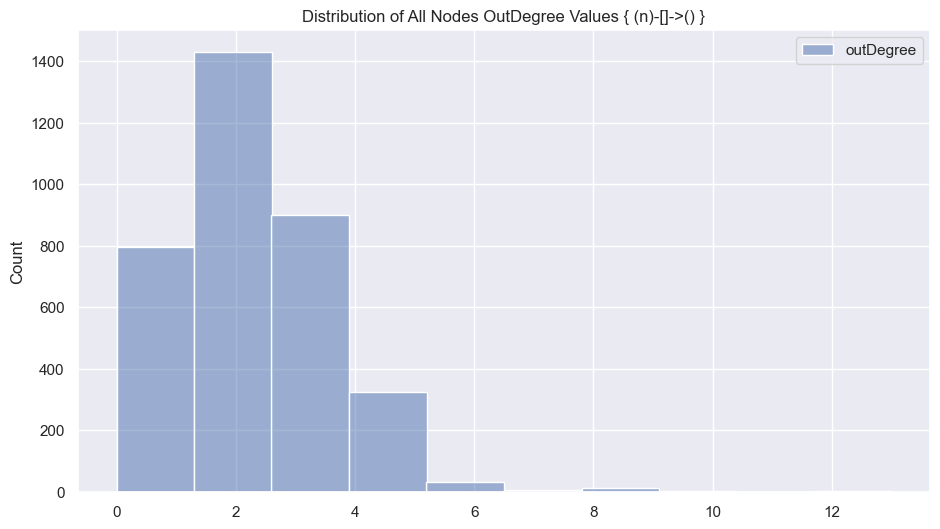

In [356]:
# Plot the distribution of all nodes outDegree values
sns.histplot(outDegree_data, bins=10).set(title='Distribution of All Nodes OutDegree Values { (n)-[]->() }')
plt.show()

## Ontological Concept Nodes

In [357]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of ontological concept nodes
ontological_concept_inDegree_stats = gds.run_cypher('''
    MATCH (c:OntologicalConcept)
    WITH c, 
      COUNT { (c)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

ontological_concept_inDegree_stats['stats'][0]

{'total': 66,
 'min': 1,
 '0.5': 6,
 'stdev': 10.963427389669633,
 '0.99': 45,
 'minNonZero': 1.0,
 'max': 64,
 '0.95': 29,
 'mean': 10.348484848484848,
 '0.9': 20,
 '0.75': 14}

In [358]:
# Generate a pandas DataFrame for the inDegree of ontological concept nodes
ontological_concept_inDegree_data = gds.run_cypher('''
  MATCH (c:OntologicalConcept)
  WITH c 
  RETURN COUNT { (c)<-[]-() } AS inDegree
''')

ontological_concept_inDegree_data.shape

(66, 1)

In [359]:
# Generate statistics from an array of ontological concept nodes inDegree values using .describe() 
gen_apoc_stats(df=ontological_concept_inDegree_data, col='inDegree')

count    66.00
mean     10.35
std      11.05
min       1.00
25%       3.00
50%       6.50
75%      14.00
90%      20.50
95%      28.75
99%      51.65
max      64.00
Name: inDegree, dtype: float64

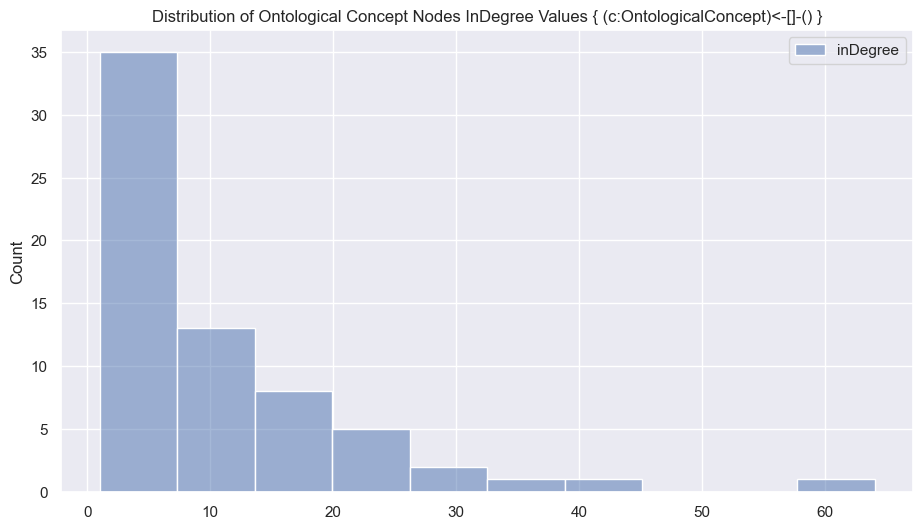

In [360]:
# Plot the distribution of ontological concept nodes inDegree values
sns.histplot(ontological_concept_inDegree_data, bins=10).set(title='Distribution of Ontological Concept Nodes InDegree Values { (c:OntologicalConcept)<-[]-() }')
plt.show()

In [361]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of ontological concept nodes
ontological_concept_outDegree_stats = gds.run_cypher('''
    MATCH (c:OntologicalConcept)
    WITH c, 
      COUNT { (c)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

ontological_concept_outDegree_stats['stats'][0]

{'total': 66,
 'min': 0,
 '0.5': 1,
 'stdev': 0.4537872464203617,
 '0.99': 1,
 'minNonZero': 1.0,
 'max': 2,
 '0.95': 1,
 'mean': 0.7727272727272727,
 '0.9': 1,
 '0.75': 1}

In [362]:
# Generate a pandas DataFrame for the outDegree of ontological concept nodes
ontological_concept_outDegree_data = gds.run_cypher('''
  MATCH (c:OntologicalConcept)
  WITH c 
  RETURN COUNT { (c)-[]->() } AS outDegree
''')

ontological_concept_outDegree_data.shape

(66, 1)

In [363]:
# Generate statistics from an array of ontological concept outDegree values using .describe() 
gen_apoc_stats(df=ontological_concept_outDegree_data, col='outDegree')

count    66.00
mean      0.77
std       0.46
min       0.00
25%       1.00
50%       1.00
75%       1.00
90%       1.00
95%       1.00
99%       1.35
max       2.00
Name: outDegree, dtype: float64

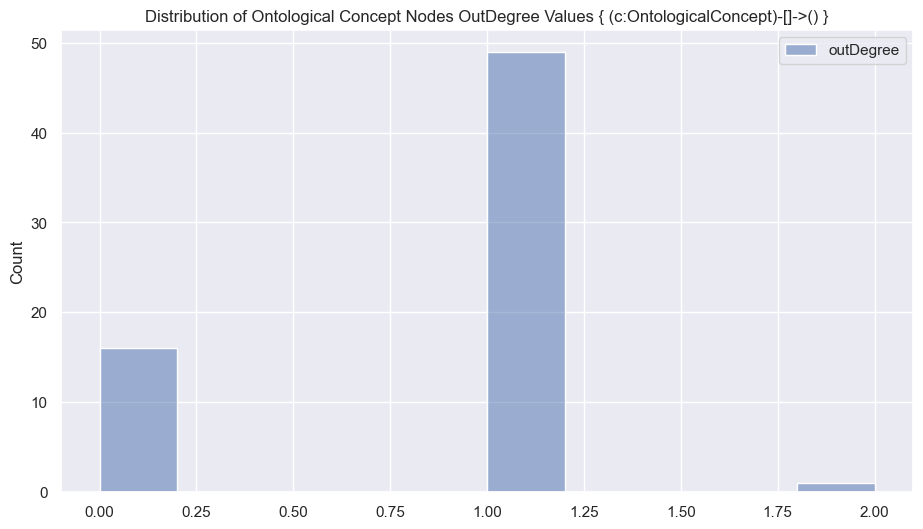

In [364]:
# Plot the distribution of ontological concept nodes outDegree values
sns.histplot(ontological_concept_outDegree_data, bins=10).set(title='Distribution of Ontological Concept Nodes OutDegree Values { (c:OntologicalConcept)-[]->() }')
plt.show()

# Dictionary Concept Nodes

In [365]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of dictionary concept nodes
dictionary_concept_inDegree_stats = gds.run_cypher('''
    MATCH (c:DictionaryConcept)
    WITH c, 
      COUNT { (c)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

dictionary_concept_inDegree_stats['stats'][0]

{'total': 638,
 'min': 0,
 '0.5': 1,
 'stdev': 9.873404912510473,
 '0.99': 60,
 'minNonZero': 1.0,
 'max': 68,
 '0.95': 20,
 'mean': 4.247648902821316,
 '0.9': 13,
 '0.75': 3}

In [366]:
# Generate a pandas DataFrame for the inDegree of dictionary concept nodes
dictionary_concept_inDegree_data = gds.run_cypher('''
  MATCH (c:DictionaryConcept)
  WITH c 
  RETURN COUNT { (c)<-[]-() } AS inDegree
''')

dictionary_concept_inDegree_data.shape

(638, 1)

In [367]:
# Generate statistics from an array of dictionary concept nodes inDegree values using .describe() 
gen_apoc_stats(df=dictionary_concept_inDegree_data, col='inDegree')

count    638.00
mean       4.25
std        9.88
min        0.00
25%        0.00
50%        1.00
75%        3.00
90%       13.00
95%       20.00
99%       58.15
max       68.00
Name: inDegree, dtype: float64

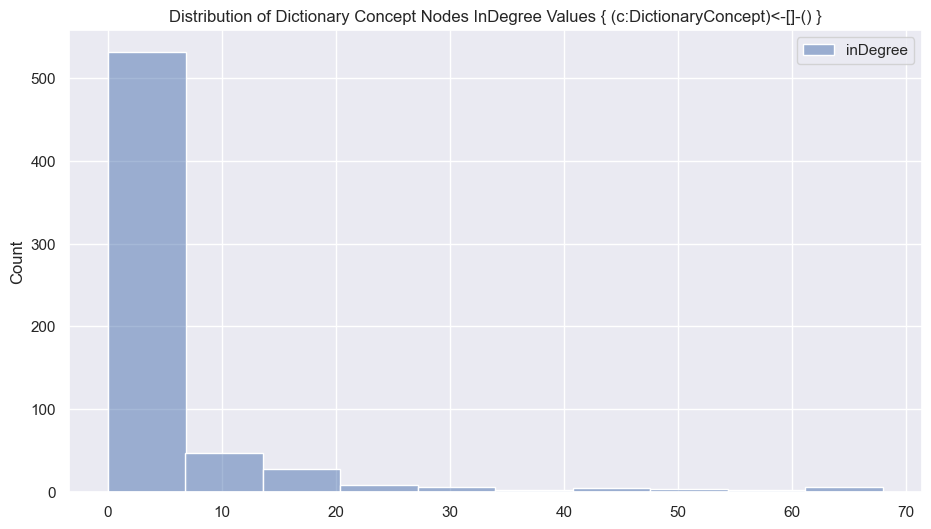

In [368]:
# Plot the distribution of dictionary concept nodes inDegree values
sns.histplot(dictionary_concept_inDegree_data, bins=10).set(title='Distribution of Dictionary Concept Nodes InDegree Values { (c:DictionaryConcept)<-[]-() }')
plt.show()

In [369]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of dictionary concept nodes
dictionary_concept_outDegree_stats = gds.run_cypher('''
    MATCH (c:DictionaryConcept)
    WITH c, 
      COUNT { (c)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

dictionary_concept_outDegree_stats['stats'][0]

{'total': 638,
 'min': 0,
 '0.5': 1,
 'stdev': 0.09651914933128936,
 '0.99': 1,
 'minNonZero': 1.0,
 'max': 1,
 '0.95': 1,
 'mean': 0.9905956112852664,
 '0.9': 1,
 '0.75': 1}

In [370]:
# Generate a pandas DataFrame for the outDegree of dictionary concept nodes
dictionary_concept_outDegree_data = gds.run_cypher('''
  MATCH (c:DictionaryConcept)
  WITH c 
  RETURN COUNT { (c)-[]->() } AS outDegree
''')

dictionary_concept_outDegree_data.shape

(638, 1)

In [371]:
# Generate statistics from an array of dictionary concept outDegree values using .describe() 
gen_apoc_stats(df=dictionary_concept_outDegree_data, col='outDegree')

count    638.00
mean       0.99
std        0.10
min        0.00
25%        1.00
50%        1.00
75%        1.00
90%        1.00
95%        1.00
99%        1.00
max        1.00
Name: outDegree, dtype: float64

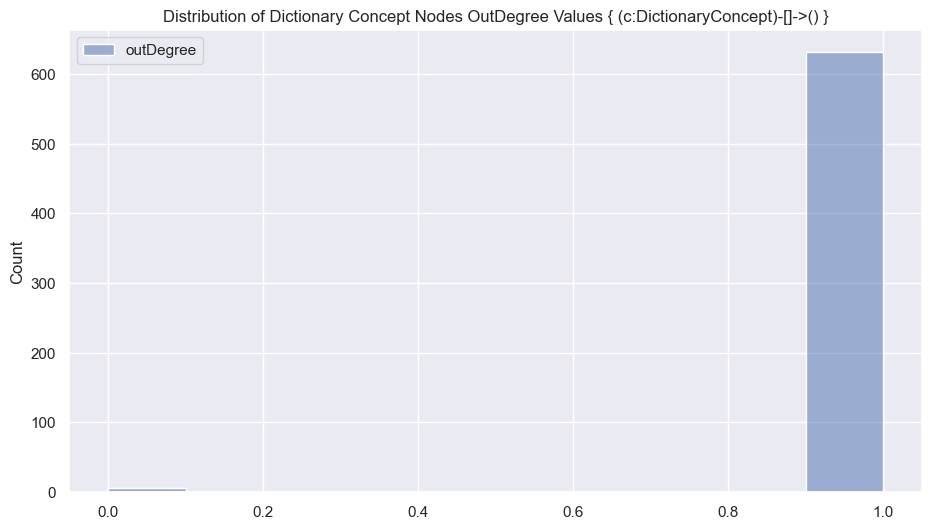

In [372]:
# Plot the distribution of dictionary concept nodes outDegree values
sns.histplot(dictionary_concept_outDegree_data, bins=10).set(title='Distribution of Dictionary Concept Nodes OutDegree Values { (c:DictionaryConcept)-[]->() }')
plt.show()

## Effector Nodes

In [373]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of Effector nodes
effector_inDegree_stats = gds.run_cypher('''
    MATCH (e:Effector)
    WITH e, 
      COUNT { (e)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

effector_inDegree_stats['stats'][0]

{'total': 1292,
 'min': 0,
 '0.5': 0,
 'stdev': 0.0,
 '0.99': 0,
 'minNonZero': 9.223372036854776e+18,
 'max': 0,
 '0.95': 0,
 'mean': 0.0,
 '0.9': 0,
 '0.75': 0}

In [374]:
# Generate a pandas DataFrame for the inDegree of Effector nodes
effector_inDegree_data = gds.run_cypher('''
  MATCH (e:Effector)
  WITH e 
  RETURN COUNT { (e)<-[]-() } AS inDegree
''')

effector_inDegree_data.shape

(1292, 1)

In [375]:
# Generate statistics from an array of Effector nodes inDegree values using .describe() 
gen_apoc_stats(df=effector_inDegree_data, col='inDegree')

count    1292.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: inDegree, dtype: float64

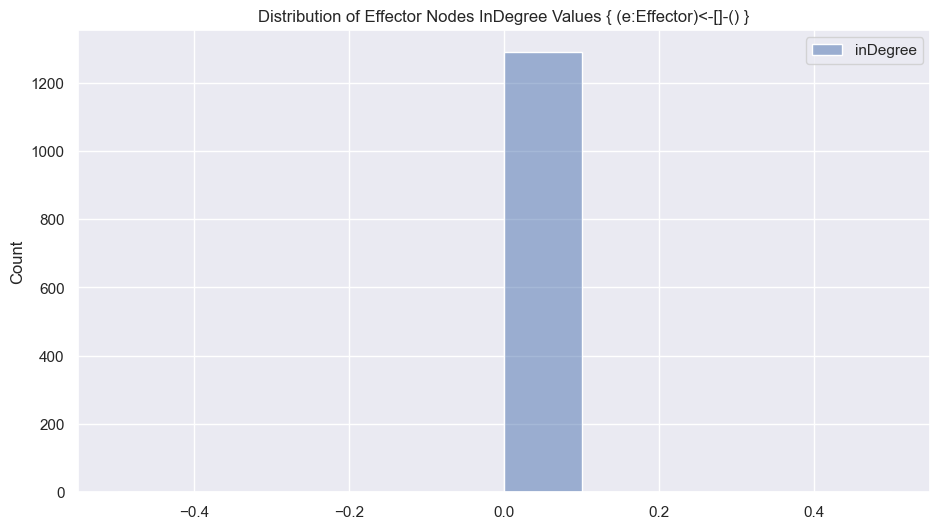

In [376]:
# Plot the distribution of Effector nodes inDegree values
sns.histplot(effector_inDegree_data, bins=10).set(title='Distribution of Effector Nodes InDegree Values { (e:Effector)<-[]-() }')
plt.show()

In [377]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of Effector nodes
effector_outDegree_stats = gds.run_cypher('''
    MATCH (e:Effector)
    WITH e, 
      COUNT { (e)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

effector_outDegree_stats['stats'][0]

{'total': 1292,
 'min': 2,
 '0.5': 3,
 'stdev': 1.0032258616171712,
 '0.99': 8,
 'minNonZero': 2.0,
 'max': 13,
 '0.95': 5,
 'mean': 3.4775541795665634,
 '0.9': 5,
 '0.75': 4}

In [378]:
# Generate a pandas DataFrame for the outDegree of Effector nodes
effector_outDegree_data = gds.run_cypher('''
  MATCH (e:Effector)
  WITH e 
  RETURN COUNT { (e)-[]->() } AS outDegree
''')

effector_outDegree_data.shape

(1292, 1)

In [379]:
# Generate statistics from an array of Effector nodes outDegree values using .describe() 
gen_apoc_stats(df=effector_outDegree_data, col='outDegree')

count    1292.00
mean        3.48
std         1.00
min         2.00
25%         3.00
50%         3.00
75%         4.00
90%         5.00
95%         5.00
99%         8.00
max        13.00
Name: outDegree, dtype: float64

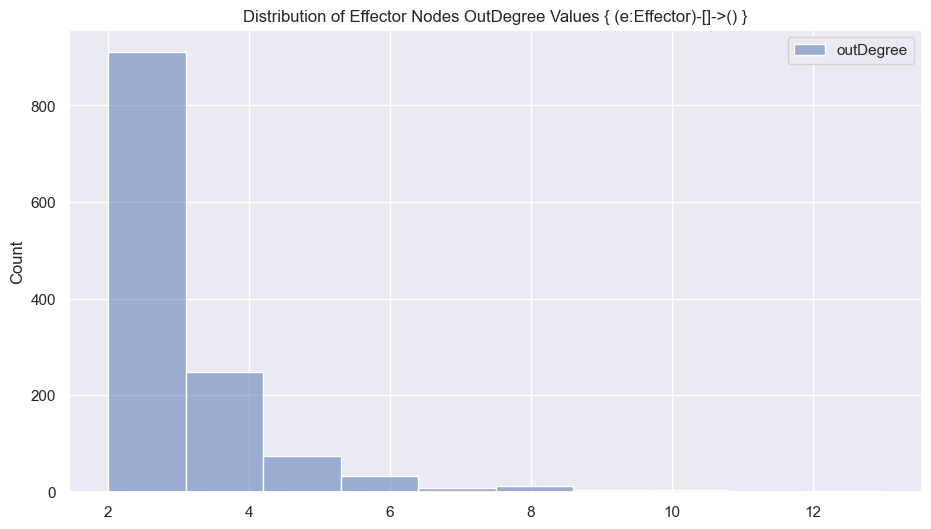

In [380]:
# Plot the distribution of Effector nodes outDegree values
sns.histplot(effector_outDegree_data, bins=10).set(title='Distribution of Effector Nodes OutDegree Values { (e:Effector)-[]->() }')
plt.show()

## Affected Nodes

In [381]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of Affected nodes
affected_inDegree_stats = gds.run_cypher('''
    MATCH (a:Affected)
    WITH a, 
      COUNT { (a)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

affected_inDegree_stats['stats'][0]

{'total': 1420,
 'min': 0,
 '0.5': 1,
 'stdev': 0.8181931869990948,
 '0.99': 5,
 'minNonZero': 1.0,
 'max': 9,
 '0.95': 3,
 'mean': 1.3443661971830987,
 '0.9': 2,
 '0.75': 1}

In [382]:
# Generate a pandas DataFrame for the inDegree of Affected nodes
affected_inDegree_data = gds.run_cypher('''
  MATCH (a:Affected)
  WITH a 
  RETURN COUNT { (a)<-[]-() } AS inDegree
''')

affected_inDegree_data.shape

(1420, 1)

In [383]:
# Generate statistics from an array of Affected nodes inDegree values using .describe() 
gen_apoc_stats(df=affected_inDegree_data, col='inDegree')

count    1420.00
mean        1.34
std         0.82
min         0.00
25%         1.00
50%         1.00
75%         1.00
90%         2.00
95%         3.00
99%         5.00
max         9.00
Name: inDegree, dtype: float64

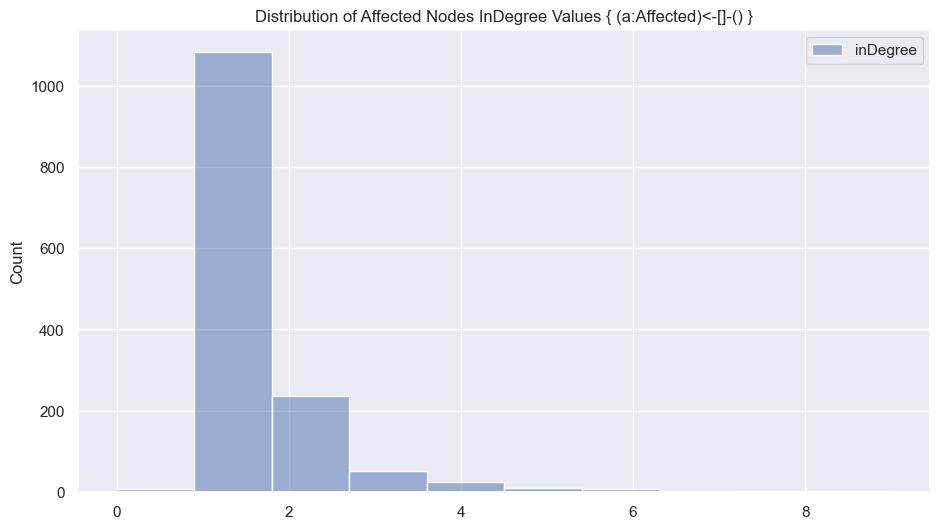

In [384]:
# Plot the distribution of Affected nodes inDegree values
sns.histplot(affected_inDegree_data, bins=10).set(title='Distribution of Affected Nodes InDegree Values { (a:Affected)<-[]-() }')
plt.show()

In [385]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of Affected nodes
affected_outDegree_stats = gds.run_cypher('''
    MATCH (a:Affected)
    WITH a, 
      COUNT { (a)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

affected_outDegree_stats['stats'][0]

{'total': 1420,
 'min': 1,
 '0.5': 2,
 'stdev': 0.026527898875827273,
 '0.99': 2,
 'minNonZero': 1.0,
 'max': 2,
 '0.95': 2,
 'mean': 1.9992957746478872,
 '0.9': 2,
 '0.75': 2}

In [386]:
# Generate a pandas DataFrame for the outDegree of Affected nodes
affected_outDegree_data = gds.run_cypher('''
  MATCH (a:Affected)
  WITH a 
  RETURN COUNT { (a)-[]->() } AS outDegree
''')

affected_outDegree_data.shape

(1420, 1)

In [387]:
# Generate statistics from an array of Affected nodes outDegree values using .describe() 
gen_apoc_stats(df=affected_outDegree_data, col='outDegree')

count    1420.00
mean        2.00
std         0.03
min         1.00
25%         2.00
50%         2.00
75%         2.00
90%         2.00
95%         2.00
99%         2.00
max         2.00
Name: outDegree, dtype: float64

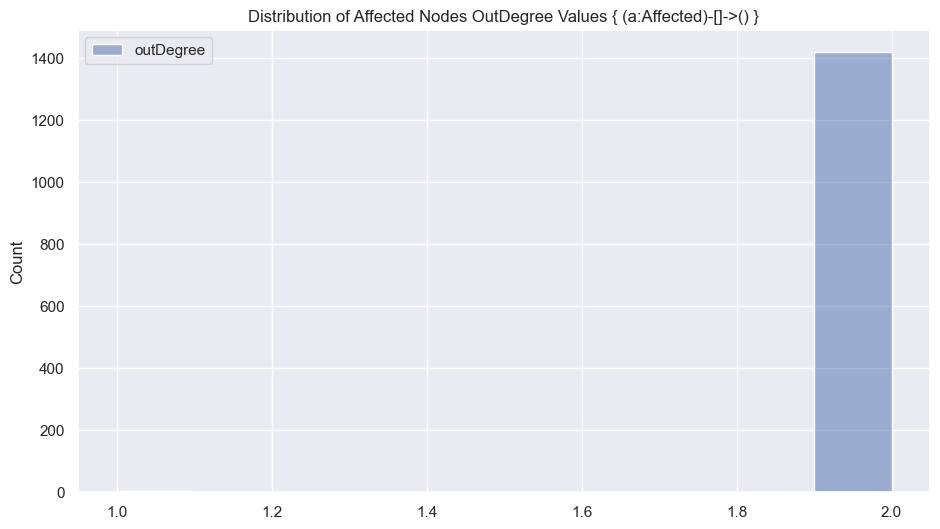

In [388]:
# Plot the distribution of Affected nodes outDegree values
sns.histplot(affected_outDegree_data, bins=10).set(title='Distribution of Affected Nodes OutDegree Values { (a:Affected)-[]->() }')
plt.show()

## Article Nodes

In [389]:
# Use apoc.agg.statistics() to calculate the inDegree statistics of Article nodes
article_inDegree_stats = gds.run_cypher('''
    MATCH (a:Article)
    WITH a, 
      COUNT { (a)<-[]-() } AS inDegree
    RETURN apoc.agg.statistics(inDegree) AS stats
    ''')

article_inDegree_stats['stats'][0]

{'total': 89,
 'min': 2,
 '0.5': 9,
 'stdev': 31.558735616512188,
 '0.99': 115,
 'minNonZero': 2.0,
 'max': 162,
 '0.95': 96,
 'mean': 23.662921348314608,
 '0.9': 69,
 '0.75': 21}

In [390]:
# Generate a pandas DataFrame for the inDegree of Article nodes
article_inDegree_data = gds.run_cypher('''
  MATCH (a:Article)
  WITH a 
  RETURN COUNT { (a)<-[]-() } AS inDegree
''')

article_inDegree_data.shape

(89, 1)

In [391]:
# Generate statistics from an array of Article nodes inDegree values using .describe() 
gen_apoc_stats(df=article_inDegree_data, col='inDegree')

count     89.00
mean      23.66
std       31.74
min        2.00
25%        5.00
50%        9.00
75%       21.00
90%       69.60
95%       94.00
99%      120.64
max      162.00
Name: inDegree, dtype: float64

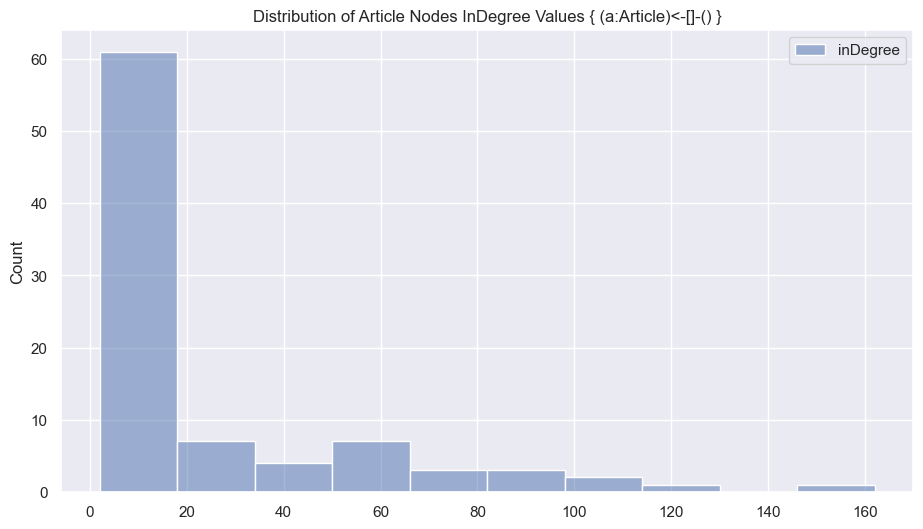

In [392]:
# Plot the distribution of Article nodes inDegree values
sns.histplot(article_inDegree_data, bins=10).set(title='Distribution of Article Nodes InDegree Values { (a:Article)<-[]-() }')
plt.show()

In [393]:
# Use apoc.agg.statistics() to calculate the outDegree statistics of Article nodes
article_outDegree_stats = gds.run_cypher('''
    MATCH (a:Article)
    WITH a, 
      COUNT { (a)-[]->() } AS outDegree
    RETURN apoc.agg.statistics(outDegree) AS stats
    ''')

article_outDegree_stats['stats'][0]

{'total': 89,
 'min': 0,
 '0.5': 0,
 'stdev': 0.0,
 '0.99': 0,
 'minNonZero': 9.223372036854776e+18,
 'max': 0,
 '0.95': 0,
 'mean': 0.0,
 '0.9': 0,
 '0.75': 0}

In [394]:
# Generate a pandas DataFrame for the outDegree of Article nodes
article_outDegree_data = gds.run_cypher('''
  MATCH (a:Article)
  WITH a 
  RETURN COUNT { (a)-[]->() } AS outDegree
''')

article_outDegree_data.shape

(89, 1)

In [395]:
# Generate statistics from an array of Article nodes outDegree values using .describe() 
gen_apoc_stats(df=article_outDegree_data, col='outDegree')

count    89.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
90%       0.0
95%       0.0
99%       0.0
max       0.0
Name: outDegree, dtype: float64

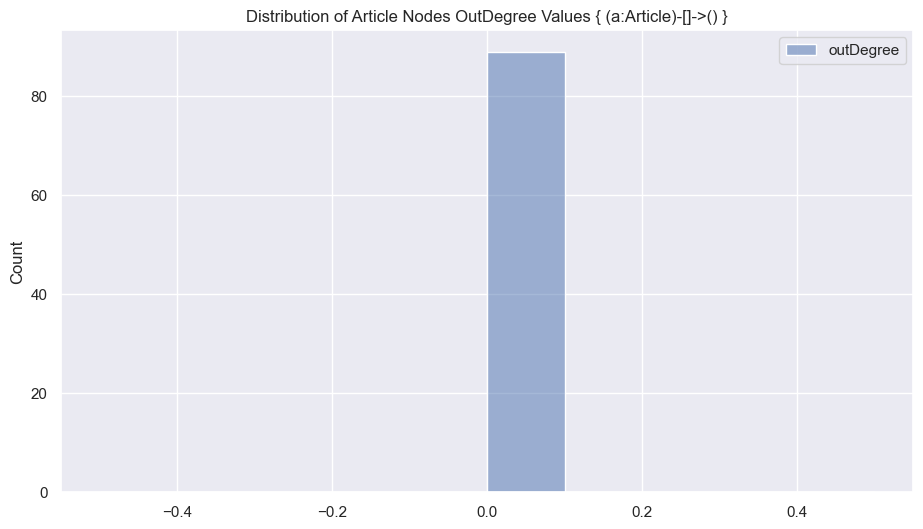

In [396]:
# Plot the distribution of Article nodes outDegree values
sns.histplot(article_outDegree_data, bins=10).set(title='Distribution of Article Nodes OutDegree Values { (a:Article)-[]->() }')
plt.show()

# Analysis of Textmining Nodes

## Distinct dictionary terms mapped for Textmining nodes

In [397]:
# Top 10 of distinct dictionary terms mapped for TextMining nodes
gds.run_cypher('''
  MATCH (t:TextMining)
  WHERE t.term IS NOT NULL
  RETURN t.term AS Term, COUNT(t.term) AS Count
  ORDER BY Count DESC LIMIT 10
''')

,Term,Count
0,growth,64
1,lactate,64
2,pH,63
3,glucose,59
4,glycosylation,51
5,cell growth,49
6,galactosylation,43
7,productivity,40
8,time,40
9,sialylation,40


## Distinct dictionary concepts mapped for Textmining nodes

In [398]:
# Top 10 of distinct dictionary concepts mapped for TextMining nodes
gds.run_cypher('''
    MATCH (t:TextMining)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)
    RETURN dc.id AS COID , dc.canonical_name AS CanonicalName, count(dc.canonical_name) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,COID,CanonicalName,Count
0,COID250920,lactate,68
1,COID367406,glucose,66
2,COID702829,cell line,65
3,COID731421,productivity,64
4,COID203666,growth,64
5,COID893209,ph,63
6,COID278523,antibody,60
7,COID626759,glycan,55
8,COID119643,glycosylation,54
9,COID242255,monoclonal antibody,51


## Distinct ontological concepts mapped for Textmining nodes

In [399]:
# Top 10 of distinct ontological concepts mapped for TextMining nodes
gds.run_cypher('''
    MATCH (t:TextMining)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)-[:IS_INSTANCE_OF]->(oc:OntologicalConcept)
    RETURN oc.id AS OntoID,  oc.name AS OntoName, count(oc.id) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,OntoID,OntoName,Count
0,C27,sugar,340
1,C61,glycosylation,214
2,C15,cell culture parameters,203
3,C11,process parameters or process control,150
4,C19,process condition,116
5,C24,clinical outcomes,113
6,C14,bioreactor conditions,108
7,C63,antibody,102
8,C9,by-product or waste,86
9,C43,media characteristics,75


# Analysis of Effector Nodes

## Distinct terms mapped for Effector nodes

In [ ]:
# Top 10 of distinct terms mapped for Effector nodes
gds.run_cypher('''
  MATCH (t:Effector)
  WHERE t.term IS NOT NULL
  RETURN t.term AS Term, COUNT(t.term) AS Count
  ORDER BY Count DESC LIMIT 10
''')

## Distinct dictionary concepts mapped for Effector nodes

In [401]:
# Top 10 of distinct dictionary concepts mapped for Effector nodes
gds.run_cypher('''
    MATCH (e:Effector)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)
    RETURN dc.id AS COID , dc.canonical_name AS CanonicalName, count(dc.canonical_name) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,COID,CanonicalName,Count
0,COID893209,ph,45
1,COID702829,cell line,42
2,COID250920,lactate,32
3,COID367406,glucose,32
4,COID626759,glycan,29
5,COID913636,media,25
6,COID806780,CHO,25
7,COID742277,time,24
8,COID921897,medium,22
9,COID203666,growth,20


## Distinct ontological concepts mapped for Effector nodes

In [402]:
# Top 10 of distinct ontological concepts mapped for Effector nodes
gds.run_cypher('''
    MATCH (e:Effector)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)-[:IS_INSTANCE_OF]->(oc:OntologicalConcept)
    RETURN oc.id AS OntoID,  oc.name AS OntoName, count(oc.id) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,OntoID,OntoName,Count
0,C27,sugar,162
1,C11,process parameters or process control,77
2,C14,bioreactor conditions,74
3,C61,glycosylation,70
4,C15,cell culture parameters,69
5,C43,media characteristics,62
6,C25,secondary raw materials,55
7,C56,cell line,45
8,C9,by-product or waste,43
9,C12,vessel or process parameter or production scale,42


# Analysis of Affected Nodes

## Distinct terms mapped for Affected nodes

In [403]:
# Top 10 of distinct dictionary terms mapped for Affected nodes
gds.run_cypher('''
  MATCH (a:Affected)
  WHERE a.term IS NOT NULL
  RETURN a.term AS Term, COUNT(a.term) AS Count
  ORDER BY Count DESC LIMIT 10
''')

,Term,Count
0,growth,44
1,glycosylation,43
2,cell growth,39
3,lactate,34
4,productivity,33
5,glucose,30
6,galactosylation,29
7,sialylation,28
8,antibody,28
9,IgG,23


## Distinct dictionary concepts of Affectd nodes

In [404]:
# Top 10 of distinct dictionary concepts mapped for Effector nodes
gds.run_cypher('''
    MATCH (a:Affected)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)
    RETURN dc.id AS COID , dc.canonical_name AS CanonicalName, count(dc.canonical_name) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,COID,CanonicalName,Count
0,COID731421,productivity,49
1,COID278523,antibody,45
2,COID203666,growth,44
3,COID119643,glycosylation,44
4,COID093598,cell growth,40
5,COID250920,lactate,36
6,COID367406,glucose,34
7,COID242255,monoclonal antibody,32
8,COID475750,galactosylation,30
9,COID713543,immunoglobulin,29


## Distinct ontological concepts mapped for Affected nodes

In [405]:
# Top 10 of distinct ontological concepts mapped for Affected nodes
gds.run_cypher('''
    MATCH (a:Affected)-[:HAS_CANONICAL_NAME]->(dc:DictionaryConcept)-[:IS_INSTANCE_OF]->(oc:OntologicalConcept)
    RETURN oc.id AS OntoID,  oc.name AS OntoName, count(oc.id) AS Count
    ORDER BY Count DESC LIMIT 10
''')

,OntoID,OntoName,Count
0,C27,sugar,178
1,C61,glycosylation,144
2,C15,cell culture parameters,134
3,C24,clinical outcomes,84
4,C19,process condition,76
5,C63,antibody,75
6,C11,process parameters or process control,73
7,C51,product quality attributes,61
8,C9,by-product or waste,43
9,C54,monoclonal antibody,43


# Analysis of Article Nodes

## Distinct years of Article nodes

In [406]:
# Count of distinct years of Article nodes
gds.run_cypher('''
  MATCH (a:Article)
  RETURN a.year AS Year, COUNT(a.year) AS Count
  ORDER BY Count DESC limit 10
''')

,Year,Count
0,2019,13
1,2018,12
2,2021,10
3,2014,9
4,2016,8


## Distinct journals of Article nodes

In [407]:
# Count of distinct journals of Article nodes
gds.run_cypher('''
  MATCH (a:Article)
  RETURN a.journal as Journal, COUNT(a.journal) AS Count
  ORDER BY Count DESC limit 10
''')

,Journal,Count
0,Biotechnology and bioengineering,24
1,Biotechnology progress,19
2,Journal of biotechnology,7
3,mAbs,5
4,Biotechnology journal,4


# Graph Projection

In [408]:
# Show all projected graphs
projected_graph = gds.graph.list()
projected_graph.size

13

In [409]:
# drop projected KG
if projected_graph.size != 0:
    gds.graph.drop(gds.graph.get('kg'))

In [ ]:
g_kg, kg_desc = gds.graph.project('kg', '*', '*')

## Degree Centrality

The Degree Centrality algorithm can be used to find popular nodes within a graph. Degree centrality measures the number of incoming or outgoing (or both) relationships from a node, depending on the orientation of a relationship projection. For more information on relationship orientations, see the relationship projection syntax section.

It can be applied to either weighted or unweighted graphs. In the weighted case the algorithm computes the sum of all positive weights of adjacent relationships of a node, for each node in the graph. Non-positive weights are ignored.

It can be applied to heterogenous graphs, however the algorithm will not calculate degree centrality per relationship type. Instead it will treat the graph as homogenous, as indicated by the algorithm traits.

In [411]:
# Get knowledge graph centrality
kg_centrality = gds.degree.stats(g_kg)
pd.DataFrame(kg_centrality)

,0
centralityDistribution,"{'min': 0.0, 'max': 13.000053405761719, 'p90': 4.000022888183594, 'p999': 10.000053405761719, 'p99': 6.000022888183594, 'p50': 2.0000076293945312, 'p75': 3.0000076293945312, 'p95': 4.000022888183594, 'mean': 2.2857210927788674}"
postProcessingMillis,24
preProcessingMillis,0
computeMillis,0
configuration,"{'orientation': 'NATURAL', 'jobId': 'df1b460a-c855-4251-b3b8-1f107d445fca', 'logProgress': True, 'nodeLabels': ['*'], 'relationshipTypes': ['*'], 'concurrency': 4, 'sudo': False}"


In [412]:
# Get knowledge graph centrality distribution
pd.DataFrame(kg_centrality)[0]['centralityDistribution']

{'min': 0.0,
 'max': 13.000053405761719,
 'p90': 4.000022888183594,
 'p999': 10.000053405761719,
 'p99': 6.000022888183594,
 'p50': 2.0000076293945312,
 'p75': 3.0000076293945312,
 'p95': 4.000022888183594,
 'mean': 2.2857210927788674}

In [413]:
# Write back degree centrality
_ = gds.degree.write(G=g_kg, 
                     writeProperty='kgDC')

In [414]:
# Get top 10 degree centrality of textmining nodes
gds.run_cypher('''
  MATCH (n:TextMining)
      WHERE n.kgDC IS NOT NULL AND n.term IS NOT NULL AND n.type IS NOT NULL
  RETURN DISTINCT
      n.term AS term,
      n.type AS type,
      n.kgDC AS degreeCentrality
  ORDER BY degreeCentrality DESC
  LIMIT 10
''')

,term,type,degreeCentrality
0,pH,bioreactor conditions,10.0
1,time,process parameters or process control,10.0
2,glycolysis,metabolic pathways,9.0
3,pCO2,process condition,9.0
4,manganese,trace metals or minerals (subset of secondary raw materials),9.0


## Weakly Connected Components

The Weakly Connected Components (WCC) algorithm finds sets of connected nodes in directed and undirected graphs. Two nodes are connected, if there exists a path between them. The set of all nodes that are connected with each other form a component. In contrast to Strongly Connected Components (SCC), the direction of relationships on the path between two nodes is not considered. For example, in a directed graph (a)→(b), a and b will be in the same component, even if there is no directed relationship (b)→(a).

WCC is often used early in an analysis to understand the structure of a graph. Using WCC to understand the graph structure enables running other algorithms independently on an identified cluster.

In [415]:
# Generate statistics for WCC
kg_wcc = gds.wcc.stats(g_kg)

In [416]:
# Create a dataframe for componentCount and componentDistribution
kg_wcc = pd.DataFrame(kg_wcc)[0][['componentCount', 'componentDistribution']]

In [417]:
# Show WCC componentCount
kg_wcc['componentCount']

7

In [418]:
# Show WCC componentDistribution
kg_wcc['componentDistribution']

{'min': 1,
 'p5': 1,
 'max': 3501,
 'p999': 3501,
 'p99': 3501,
 'p1': 1,
 'p10': 1,
 'p90': 3501,
 'p50': 1,
 'p25': 1,
 'p75': 1,
 'p95': 3501,
 'mean': 501.0}

In [419]:
# Write WCCs to graph 
_ = gds.wcc.write(G=g_kg, writeProperty='kgWcc')

In [420]:
# View top components
kg_WCCs = gds.run_cypher('''
  MATCH (n)
    WHERE n.kgWcc IS NOT NULL
  RETURN n.kgWcc AS wcc, 
        COUNT(n.kgWcc) AS wccSize
  ORDER BY wccSize DESC
''')

kg_WCCs.shape

(7, 2)

In [421]:
# Get top 10 weakly connected components
kg_WCCs.head(10)

,wcc,wccSize
0,0,3501
1,178,1
2,226,1
3,378,1
4,548,1
5,579,1
6,587,1


### View WCCs in Browser

In [422]:
# Run the cypher queruy below to view the most connect component in Neo4j browser

MATCH (n)
WHERE n.kgWcc IN [0]
RETURN *

'\nMATCH (n)\nWHERE n.kgWcc IN [0]\nRETURN *\n'

## Strongly Connected Components

The Strongly Connected Components (SCC) algorithm finds maximal sets of connected nodes in a directed graph. A set is considered a strongly connected component if there is a directed path between each pair of nodes within the set. It is often used early in a graph analysis process to help us get an idea of how our graph is structured.

In [423]:
# Generate statistics for SCC
kg_scc = gds.scc.stats(g_kg)

In [424]:
# Create a dataframe for componentCount and componentDistribution
kg_scc = pd.DataFrame(kg_scc)[0][['componentCount', 'componentDistribution']]

In [425]:
# Show SCC componentCount
kg_scc['componentCount']

3507

In [426]:
# Show SCC componentDistribution
kg_scc['componentDistribution']

{'min': 1,
 'p5': 1,
 'max': 1,
 'p999': 1,
 'p99': 1,
 'p1': 1,
 'p10': 1,
 'p90': 1,
 'p50': 1,
 'p25': 1,
 'p75': 1,
 'p95': 1,
 'mean': 1.0}

In [427]:
# Write SCCs to graph 
_ = gds.scc.write(G=g_kg, writeProperty='kgScc')

In [428]:
# View top components
kg_SCCs = gds.run_cypher('''
  MATCH (n)
    WHERE n.kgScc IS NOT NULL
  RETURN n.kgScc AS scc, 
        COUNT(n.kgScc) AS sccSize
  ORDER BY sccSize DESC
''')

kg_SCCs.shape

(3507, 2)

In [429]:
# Get top 10 strongly connected components
kg_SCCs.head(10)

,scc,sccSize
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


### View SCCs in Browser

In [430]:
# Run the cypher query below to view the most connect component in Neo4j browser

MATCH (n)
WHERE n.kgScc IN [0]
RETURN *


'\nMATCH (n)\nWHERE n.kgScc IN [0]\nRETURN *\n'

# PageRank

The PageRank algorithm measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes. The underlying assumption roughly speaking is that a page is only as important as the pages that link to it.

PageRank is introduced in the original Google paper as a function that solves the following equation:

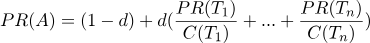

where,

- we assume that a page A has pages T1 to Tn which point to it.
- d is a damping factor which can be set between 0 (inclusive) and 1 (exclusive). It is usually set to 0.85.
- C(A) is defined as the number of links going out of page A.

This equation is used to iteratively update a candidate solution and arrive at an approximate solution to the same equation.

In [431]:
kg_PageRank = gds.pageRank.write(G=g_kg, writeProperty='kgPageRank')

In [432]:
pd.DataFrame(kg_PageRank)[0]['centralityDistribution']

{'min': 0.14999961853027344,
 'max': 39.284422874450684,
 'p90': 0.2987508773803711,
 'p999': 35.635985374450684,
 'p99': 4.700316429138184,
 'p50': 0.17549991607666016,
 'p75': 0.19249916076660156,
 'p95': 0.709406852722168,
 'mean': 0.3855337956572381}

In [433]:
# Get top 10 PageRank nodes
gds.run_cypher('''
  MATCH (n)
      WHERE n.kgPageRank IS NOT NULL AND n.term IS NOT NULL AND n.type IS NOT NULL
  RETURN DISTINCT
      //n.pmid AS pmid,
      n.term AS term,
      n.type AS type,
      //n.np AS noun_phrase,
      n.kgPageRank AS pageRank
  ORDER BY pageRank DESC
  LIMIT 10
''')

,term,type,pageRank
0,time,process parameters or process control,0.532500
1,sialylation,glycosylation,0.458125
2,biological activities,clinical outcomes,0.405000
3,N-glycosylation,glycosylation,0.405000
4,CQAs,product quality attributes,0.362500


### View Top PageRank nodes in Browser

In [434]:
# Run the cypher query below to view top pagerank nodes in Neo4j browser

MATCH (n)-[r]-(m)
WHERE n.term IN ['time', 'sialylation', 'biological activities', 'N-glycosylation', 'CQAs']
RETURN n, r, m

"\nMATCH (n)-[r]-(m)\n//WHERE n.term IN ['antibody-dependent cell-mediated cytotoxicity', 'ADCC', 'glycosylation']\nWHERE n.term IN ['glycans', 'afucosylation', 'n-glycosylation profile']\nRETURN n, r, m\n"

# Node Similarity

The Node Similarity algorithm compares a set of nodes based on the nodes they are connected to. Two nodes are considered similar if they share many of the same neighbors. Node Similarity computes pair-wise similarities based on either the Jaccard metric, also known as the Jaccard Similarity Score, or the Overlap coefficient, also known as the Szymkiewicz–Simpson coefficient.

Given two sets A and B, the Jaccard Similarity is computed using the following formula:

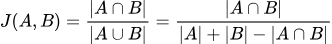

The Overlap coefficient is computed using the following formula:

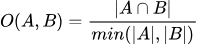

The input of this algorithm is a bipartite, connected graph containing two disjoint node sets. Each relationship starts from a node in the first node set and ends at a node in the second node set.

The Node Similarity algorithm compares each node that has outgoing relationships with each other such node. For every node n, we collect the outgoing neighborhood N(n) of that node, that is, all nodes m such that there is a relationship from n to m. For each pair n, m, the algorithm computes a similarity for that pair that equals the outcome of the selected similarity metric for N(n) and N(m).

Node Similarity has time complexity O(n3) and space complexity O(n2). We compute and store neighbour sets in time and space O(n2), then compute pairwise similarity scores in time O(n3).

In order to bound memory usage you can specify an explicit limit on the number of results to output per node, this is the 'topK' parameter. It can be set to any value, except 0. You will lose precision in the overall computation of course, and running time is unaffected - we still have to compute results before potentially throwing them away.

The output of the algorithm are new relationships between pairs of the first node set. Similarity scores are expressed via relationship properties.

In [435]:
gds.run_cypher('''
CALL gds.nodeSimilarity.stream('kg')
YIELD node1, node2, similarity
RETURN DISTINCT gds.util.asNode(node1).term AS node1, gds.util.asNode(node2).term AS node2, similarity
ORDER BY similarity DESCENDING, node1, node2
LIMIT 10
''')

,node1,node2,similarity
0,2-F-peracetyl fucose,2-F-peracetyl fucose,1.0
1,ADCC,ADCC,1.0
2,ADCC,antibody-dependent cell-mediated cytotoxicity,1.0
3,ADCC,antibody-dependent cellular cytotoxicity,1.0
4,Amino acids,amino acid,1.0
5,Amino acids,amino acids,1.0
6,Antibody,antibody,1.0
7,BA,butyric acid,1.0
8,Bioreactors,bioreactor,1.0
9,Bioreactors,bioreactors,1.0
